In this notebook we find the version of EfficientNetV2S(std. augment) towed on the dataset obtained by using smote.
For the purpose of the final result gave the same performance as using the original dataset :(

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install neptune
!pip install neptune-tensorflow-keras
!pip install keras-cv

import neptune
from datetime import date
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_cv as tfkv
from tensorflow import keras as tfk
from keras import applications
from tensorflow.keras.applications import MobileNetV2
from keras import layers as tfkl
from tensorflow.keras import mixed_precision
from io import StringIO
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import keras_cv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=7b915489de5498497a6364e1d63672345a16c340213c0ffe9ad73ba521ac7fe9
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63ed4e40f0f0012a438106f220bce4ccba
Successfully built bravado-core
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

Load the SMOTE dataset

In [ ]:
# Converting to one-hot encoding
seed = 90
!cp /content/drive/MyDrive/smote_split_data.npz .
data = np.load('smote_split_data.npz')
X_train = data['train_images']
y_train = data['train_labels']
X_val = data['val_images']
y_val = data['val_labels']

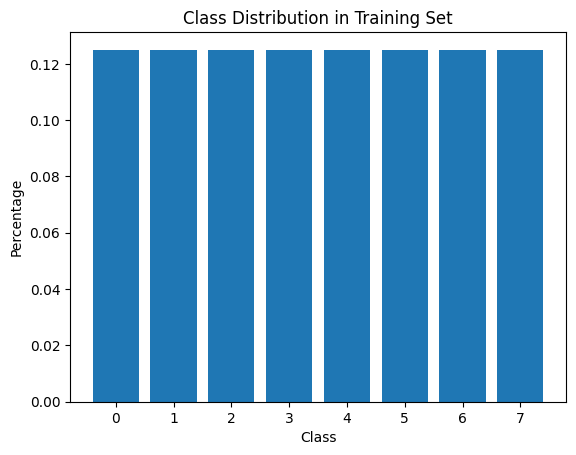

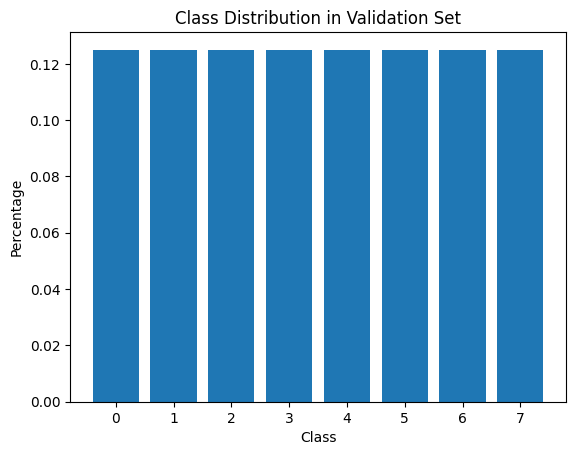

In [ ]:

def plot_class_distribution(y, title):
  num_samples = np.zeros(8)
  tmp_y = np.argmax(y, axis=1)
  for i in range(8):
    num_samples[i] = np.sum(tmp_y == i)
  plt.bar(range(8), num_samples / np.sum(num_samples))
  plt.xlabel('Class')
  plt.ylabel('Percentage')
  plt.title(title)
  plt.show()

plot_class_distribution(y_train, 'Class Distribution in Training Set')
plot_class_distribution(y_val, 'Class Distribution in Validation Set')


# Parameters and Hyperparameters

In [4]:
data_params = {
    'batch_size': 32,
    'input_shape': (96, 96, 3),
    'num_classes': 8,
    'seed': 90
}

HYPERPARAMETERS = {
    "BATCH_SIZE": 32,
    "EPOCHS": 200,
    "LEARNING_RATE": 0.001,
    "LEARNING_DESCENT_PATIENCE": 5,
    "LEARNING_DESCENT_FACTOR": 0.5,
    "EARLY_STOPPING_PATIENCE": 10,
    "DROPOUT": 0.4,
    "LAYERS_FINE_TUNE": 400,
    "MODEL_NAME": "",
    "RAND_AUGMENT_MAGNITUDE": 0.4,
    "RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE": 2
}

# Build the model

## Augmentations

In [5]:
AUTO = tf.data.AUTOTUNE


grid_mask = keras_cv.layers.GridMask(
      ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant", fill_value=0.0)

cutout_constant = keras_cv.layers.RandomCutout(height_factor = 0.5, width_factor = 0.5, fill_mode="constant")

randomZoom = keras_cv.layers.RandomZoom(height_factor=0.5, width_factor=0.5)

hue = keras_cv.layers.RandomHue(factor=0.3, value_range=(0, 255))

channelShuffle = keras_cv.layers.ChannelShuffle(groups=3)

channelShift = keras_cv.layers.RandomChannelShift(value_range=(0, 255),factor=0.3)

simple_aug = tfk.Sequential(
    [
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomRotation(factor=0.1, fill_mode = "nearest"),
        tfkl.RandomZoom(height_factor=0.1, width_factor=0.1, fill_mode = "nearest"),
    ]
)


rand_augment = tfkv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=HYPERPARAMETERS['RAND_AUGMENT_AUGMENTATIONS_PER_IMAGE'],
    magnitude=HYPERPARAMETERS['RAND_AUGMENT_MAGNITUDE'],
    geometric = True
)

grid_mask_or_rand_cutout = [
    cutout_constant,
    grid_mask
]

color_trasformations = [
     hue,
     channelShuffle,
     channelShift
]


def augment(images):
  image = tf.cast(images, tf.uint8)
  images = simple_aug(image)
  images = rand_augment(images)
  images = keras_cv.layers.RandomChoice(layers=grid_mask_or_rand_cutout)(images)
  images = keras_cv.layers.RandomChoice(layers=color_trasformations)(images)

  return images


## Data loaders

In [ ]:

train_data = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(HYPERPARAMETERS['EPOCHS'] * 100)
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

val_data = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(HYPERPARAMETERS['BATCH_SIZE'])
    .map(
        lambda x, y: (augment(x), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)


### Plotting to see the augmentations

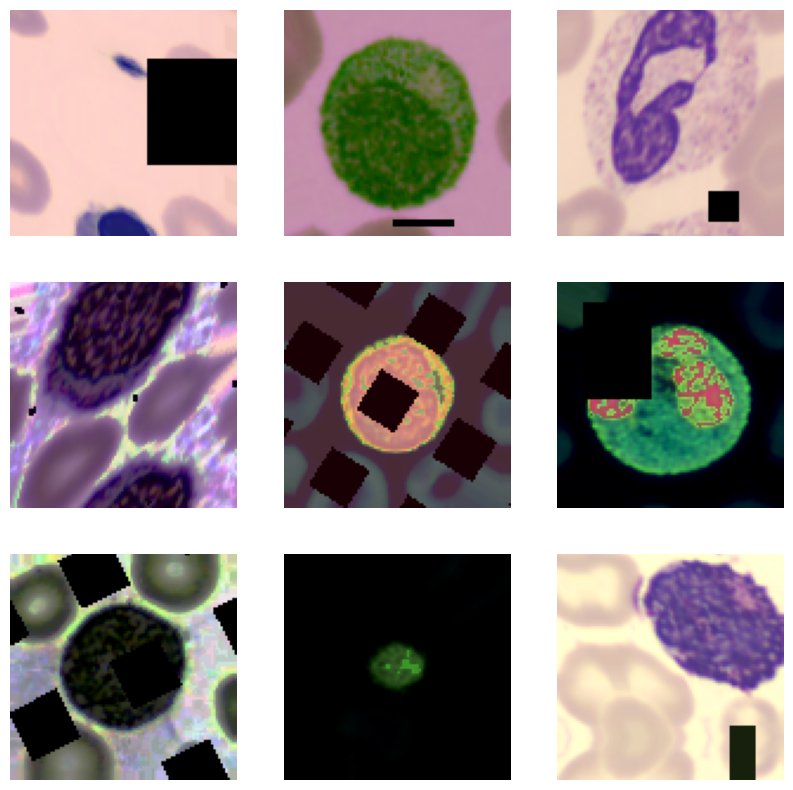

In [ ]:
sample_images, _ = next(iter(train_data))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")


## Model Definition

In [ ]:
print('Loading model with ImageNet weights...')
MODEL_IMPORTED =tfk.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=data_params['input_shape'],
    pooling="avg",
    classes=8,
    classifier_activation="softmax",
    include_preprocessing=True,
    name="efficientnetv2-s",
)

# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
MODEL_IMPORTED.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = HYPERPARAMETERS['LAYERS_FINE_TUNE']
num_layers = len(MODEL_IMPORTED.layers)

print("Num_layers fine tune " + str(num_layers_fine_tune))
print("Num_layers: " + str(num_layers))

# Freeze the initial layers in the convolutional base.
for model_layer in MODEL_IMPORTED.layers[:num_layers - num_layers_fine_tune]:
    model_layer.trainable = False

print(f"\nConfigured to fine tune the last", num_layers_fine_tune, "convolutional layers...\n")

Loading model with ImageNet weights...
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Num_layers fine tune 400
Num_layers: 514

Configured to fine tune the last 400 convolutional layers...



In [ ]:
def build_model():
  """Builds the Keras model.
  """
  inputs = tf.keras.Input(shape=data_params['input_shape'])

  # Wrap the augmentation layer in a tf.function
  # Wrap augment_image in tf.py_function to execute eagerly

  x = MODEL_IMPORTED(inputs)

  x = tfkl.Dense(128, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)
  x = tfkl.Dense(64, activation='relu')(x)
  x = tfkl.Dropout(HYPERPARAMETERS['DROPOUT'])(x)


  outputs = tfkl.Dense(data_params['num_classes'], activation='softmax')(x)

  model = tfk.Model(inputs=inputs, outputs=outputs)
  print(model.summary())

  return model

In [ ]:

model = build_model()

# Costruisci il modello

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=HYPERPARAMETERS["LEARNING_RATE"]),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 1280)                │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,504,104 (78.22 MB)

 Trainable params: 18,970,352 (72.37 MB)

 Non-trainable params: 1,533,752 (5.85 MB)

None


Configuration of Neptune

In [ ]:
!mkdir /content/drive/MyDrive/savage_model
# prompt: class neptune callback

run = neptune.init_run(
    project=f"lp1807/Homework1" , # Replace with your Neptune project
    api_token="API_TOKEN",
    name="EfficientNetV2S-withFineTune_SMOTE"
)

# Create a NeptuneCallback
class NeptuneCallback(tfk.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        run["model/train/accuracy"].log(logs["accuracy"])
        run["model/train/loss"].log(logs["loss"])
        run["model/val/accuracy"].log(logs["val_accuracy"])
        run["model/val/loss"].log(logs["val_loss"])


def saveNeptune_Drive():

  # Log the entire history dictionary to Neptune
  run["training/history"] = history.history  # <-- This line logs the entire training history

  for epoch in range(len(history.history['accuracy'])):
    run["training/epoch/train_accuracy"].log(history.history['accuracy'][epoch])
    run["training/epoch/val_accuracy"].log(history.history['val_accuracy'][epoch])
    run["training/epoch/train_loss"].log(history.history['loss'][epoch])
    run["training/epoch/val_loss"].log(history.history['val_loss'][epoch])

  model_summary = StringIO()
  model.summary(print_fn=lambda x: model_summary.write(x + "\n"))
  run["model/summary"] = model_summary.getvalue()

  # Log model weights and configuration
  run["model/weights"] = neptune.types.File.as_pickle(model.get_weights())
  run["model/config"] = model.get_config()

  model_file_path = f"/content/drive/MyDrive/savage_model/prova.keras"
  model.save(model_file_path)

  # Log the .keras model file to Neptune
  run["model/file"].upload(model_file_path)

  # Convert history to DataFrame and save as CSV
  history_df = pd.DataFrame(history.history)
  history_file_path = f"/content/drive/MyDrive/savage_model/prova_training_history.csv"
  history_df.to_csv(history_file_path, index=False)

  # Log the CSV file to Neptune
  run["training/history_file"].upload(history_file_path)
  run["notebook"].upload("/content/drive/MyDrive/Colab Notebooks/SMOTE.ipynb")

def saveHyperparameters():
    # Saving as Json
    run["hyperparameters"] = HYPERPARAMETERS

mkdir: cannot create directory ‘/content/drive/MyDrive/savage_model’: File exists
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/lp1807/Homework1/e/HOM-303


In [ ]:
!mkdir /content/drive/MyDrive/savage_model/checkpoints

# Define the checkpoint directory on Google Drive or locally
checkpoint_dir = '/content/drive/MyDrive/savage_model/checkpoints/'  # Modify this path as needed
os.makedirs(checkpoint_dir, exist_ok=True)
saveHyperparameters()

#neptune_cbk = NeptuneCallback()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir  + "checkpoints/ep{epoch:02d}-acc{accuracy:.3f}.keras",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch",
    monitor = 'val_loss',

)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=HYPERPARAMETERS["EARLY_STOPPING_PATIENCE"],  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau callback to decrease the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=HYPERPARAMETERS["LEARNING_DESCENT_FACTOR"],  # Reduce the learning rate by a factor of 0.5
    patience=HYPERPARAMETERS["LEARNING_DESCENT_PATIENCE"],  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # Print out a message when learning rate is reduced
)

# Train the model with the callbacks
history = model.fit(
    train_data,
    epochs=HYPERPARAMETERS["EPOCHS"],
    validation_data=val_data,
    callbacks=[ early_stopping, reduce_lr, checkpoint_callback]  # Include both the callbacks here
)

saveNeptune_Drive()

mkdir: cannot create directory ‘/content/drive/MyDrive/savage_model/checkpoints’: File exists
Epoch 1/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 360s 492ms/step - accuracy: 0.5020 - loss: 1.3977 - val_accuracy: 0.8597 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 2/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 176s 375ms/step - accuracy: 0.8105 - loss: 0.6138 - val_accuracy: 0.8871 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 3/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 173s 369ms/step - accuracy: 0.8557 - loss: 0.4675 - val_accuracy: 0.8841 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 4/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 188s 401ms/step - accuracy: 0.8680 - loss: 0.4273 - val_accuracy: 0.9117 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 5/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 189s 403ms/step - accuracy: 0.8847 - loss: 0.3818 - val_accuracy: 0.9109 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 6/200
466/466 ━━━━━━━━━━━━━━━━━━━━ 185s 366ms/step - accuracy: 0.8965 - loss: 0.3477 - val_accuracy: 0.9104 - val_l

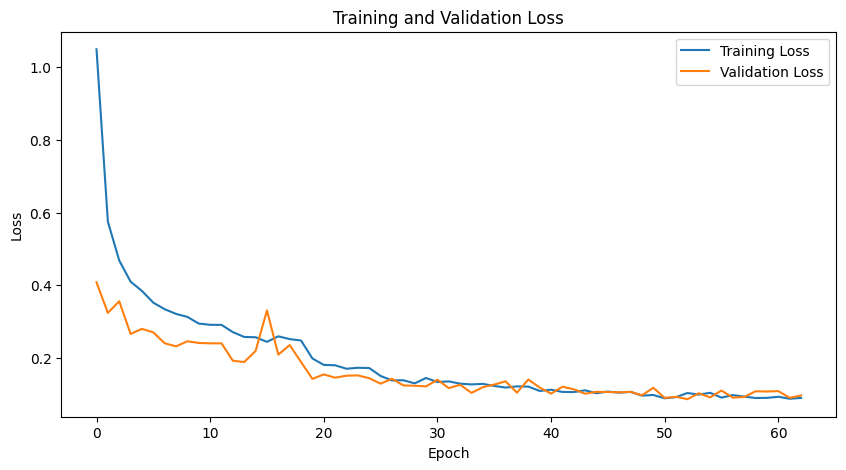

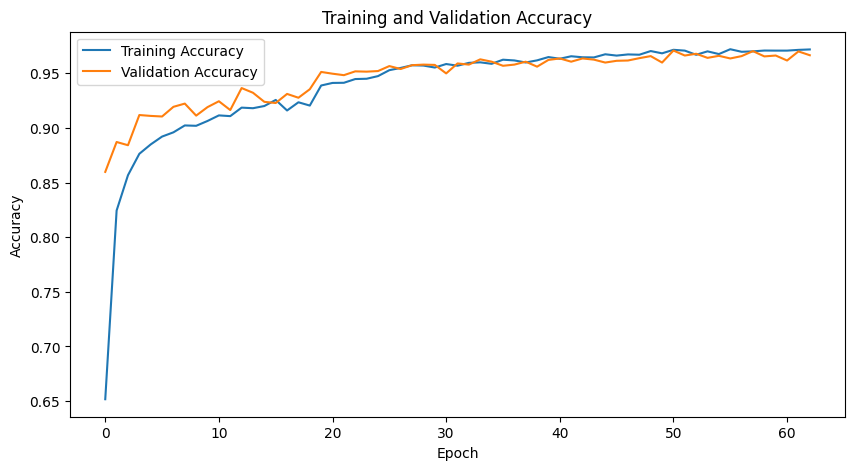

In [ ]:
# prompt: plot loss and accuracy on training and validation through tranining

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/SMOTE_model.keras')